In [78]:
import torch
import os
import copy
import sys
from pathlib import Path
from dataclasses import dataclass, field
from typing import Optional
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
import random
from torch.optim import LBFGS, Adam
from pathlib import Path
from tqdm import tqdm
import wandb

# make sure that util is correctly accessed from parent directory
ppp_dir = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if ppp_dir not in sys.path:
    sys.path.insert(0, ppp_dir)


In [79]:
wandb.login()

True

In [80]:
'''def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class WaveAct(nn.Module):
    def __init__(self):
        super(WaveAct, self).__init__()
        self.w1 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        return self.w1 * torch.sin(x)+ self.w2 * torch.cos(x)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=256):
        super(FeedForward, self).__init__()
        self.linear = nn.Sequential(*[
            nn.Linear(d_model, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_model)
        ])

    def forward(self, x):
        return self.linear(x)


class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()

        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()

    def forward(self, x):
        x2 = self.act1(x)
        # pdb.set_trace()
        x = x + self.attn(x2,x2,x2)[0]
        x2 = self.act2(x)
        x = x + self.ff(x2)
        return x


class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()

        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()

    def forward(self, x, e_outputs):
        x2 = self.act1(x)
        x = x + self.attn(x2, e_outputs, e_outputs)[0]
        x2 = self.act2(x)
        x = x + self.ff(x2)
        return x


class Encoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super(Encoder, self).__init__()
        self.N = N
        self.layers = get_clones(EncoderLayer(d_model, heads), N)
        self.act = WaveAct()

    def forward(self, x):
        for i in range(self.N):
            x = self.layers[i](x)
        return self.act(x)


class Decoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super(Decoder, self).__init__()
        self.N = N
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        self.act = WaveAct()

    def forward(self, x, e_outputs):
        for i in range(self.N):
            x = self.layers[i](x, e_outputs)
        return self.act(x)


class PINNsformer(nn.Module):
    def __init__(self, d_out, d_model, d_hidden, N, heads):
        """
        Adapted PINNsformer that takes three inputs: x, t, and rho.
        Args:
            d_out (int): Output dimension.
            d_model (int): Dimension of the model embeddings.
            d_hidden (int): Hidden layer dimension in the output MLP.
            N (int): Number of encoder/decoder layers.
            heads (int): Number of attention heads.
        """
        super(PINNsformer, self).__init__()
        # Change input dimension from 2 to 3 to accommodate x, t, and rho
        self.linear_emb = nn.Linear(3, d_model)

        self.encoder = Encoder(d_model, N, heads)
        self.decoder = Decoder(d_model, N, heads)
        self.linear_out = nn.Sequential(
            nn.Linear(d_model, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_out)
        )

    def forward(self, x, t, rho):
        # Concatenate x, t, and rho along the last dimension
        src = torch.cat((x, t, rho), dim=-1)
        src = self.linear_emb(src)

        e_outputs = self.encoder(src)
        d_output = self.decoder(src, e_outputs)
        output = self.linear_out(d_output)
        return output'''

'def get_clones(module, N):\n    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])\n\nclass WaveAct(nn.Module):\n    def __init__(self):\n        super(WaveAct, self).__init__()\n        self.w1 = nn.Parameter(torch.ones(1), requires_grad=True)\n        self.w2 = nn.Parameter(torch.ones(1), requires_grad=True)\n\n    def forward(self, x):\n        return self.w1 * torch.sin(x)+ self.w2 * torch.cos(x)\n\nclass FeedForward(nn.Module):\n    def __init__(self, d_model, d_ff=256):\n        super(FeedForward, self).__init__()\n        self.linear = nn.Sequential(*[\n            nn.Linear(d_model, d_ff),\n            WaveAct(),\n            nn.Linear(d_ff, d_ff),\n            WaveAct(),\n            nn.Linear(d_ff, d_model)\n        ])\n\n    def forward(self, x):\n        return self.linear(x)\n\n\nclass EncoderLayer(nn.Module):\n    def __init__(self, d_model, heads):\n        super(EncoderLayer, self).__init__()\n\n        self.attn = nn.MultiheadAttention(embed_dim=d_model, 

In [81]:
def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class WaveAct(nn.Module):
    def __init__(self):
        super(WaveAct, self).__init__() 
        self.w1 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        return self.w1 * torch.sin(x)+ self.w2 * torch.cos(x)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=256):
        super(FeedForward, self).__init__() 
        self.linear = nn.Sequential(*[
            nn.Linear(d_model, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_ff),
            WaveAct(),
            nn.Linear(d_ff, d_model)
        ])

    def forward(self, x):
        return self.linear(x)


class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()

        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()
        
    def forward(self, x):
        x2 = self.act1(x)
        # pdb.set_trace()
        x = x + self.attn(x2,x2,x2)[0]
        x2 = self.act2(x)
        x = x + self.ff(x2)
        return x


class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()

        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, batch_first=True)
        self.ff = FeedForward(d_model)
        self.act1 = WaveAct()
        self.act2 = WaveAct()

    def forward(self, x, e_outputs): 
        x2 = self.act1(x)
        x = x + self.attn(x2, e_outputs, e_outputs)[0]
        x2 = self.act2(x)
        x = x + self.ff(x2)
        return x


class Encoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super(Encoder, self).__init__()
        self.N = N
        self.layers = get_clones(EncoderLayer(d_model, heads), N)
        self.act = WaveAct()

    def forward(self, x):
        for i in range(self.N):
            x = self.layers[i](x)
        return self.act(x)


class Decoder(nn.Module):
    def __init__(self, d_model, N, heads):
        super(Decoder, self).__init__()
        self.N = N
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        self.act = WaveAct()
        
    def forward(self, x, e_outputs):
        for i in range(self.N):
            x = self.layers[i](x, e_outputs)
        return self.act(x)


class PINNsformer_params(nn.Module):
    def __init__(self, d_out, d_model, d_hidden, N, heads):
        """
        Adapted PINNsformer that takes three inputs: x, t, and rho.
        Args:
            d_out (int): Output dimension.
            d_model (int): Dimension of the model embeddings.
            d_hidden (int): Hidden layer dimension in the output MLP.
            N (int): Number of encoder/decoder layers.
            heads (int): Number of attention heads.
        """
        super(PINNsformer_params, self).__init__()
        # Change input dimension from 2 to 3 to accommodate x, t, and rho
        self.linear_emb = nn.Linear(3, d_model)

        self.encoder = Encoder(d_model, N, heads)
        self.decoder = Decoder(d_model, N, heads)
        self.linear_out = nn.Sequential(
            nn.Linear(d_model, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_hidden),
            WaveAct(),
            nn.Linear(d_hidden, d_out)
        )

    def forward(self, x, t, rho):
        # Concatenate x, t, and rho along the last dimension
        src = torch.cat((x, t, rho), dim=-1)
        src = self.linear_emb(src)

        e_outputs = self.encoder(src)
        d_output = self.decoder(src, e_outputs)
        output = self.linear_out(d_output)
        return output

In [82]:
class PDEData(Dataset):
    def __init__(self, x_range, t_range, rho_values, x_points, t_points, device='cpu', use_time_sequencing=False):
        """
        Initialize the dataset for PDE data with multiple rho values.

        Args:
            x_range (list): Spatial domain [x_min, x_max].
            t_range (list): Temporal domain [t_min, t_max].
            rho_values (list): List of rho values for different scenarios.
            x_points (int): Number of points in the spatial domain.
            t_points (int): Number of points in the temporal domain.
            device (str): Device to store the tensors ('cpu' or 'cuda').
        """
        self.device = "cpu"
        self.x_range = x_range
        self.t_range = t_range
        self.rho_values = rho_values  # Store multiple rho values
        self.x_points = x_points
        self.t_points = t_points
        self.use_time_sequencing = use_time_sequencing

        # Prepare data for each rho value.
        self.data = {}
        for rho in rho_values:
            # Generate the data for all rho values

            res, b_left, b_right, b_upper, b_lower = self._generate_data()
            if self.use_time_sequencing == True:
                res = self._make_time_sequence(res)
                b_left = self._make_time_sequence(b_left)
                b_right = self._make_time_sequence(b_right)
                b_upper = self._make_time_sequence(b_upper)
                b_lower = self._make_time_sequence(b_lower)

            # Convert boundary points to PyTorch tensors
            b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(self.device)
            b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(self.device)
            b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(self.device)
            b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(self.device)

            self.data[rho] = {
                'res': torch.tensor(res, dtype=torch.float32, requires_grad=True).to(self.device),
                'b_left': b_left,
                'b_right': b_right,
                'b_upper': b_upper,
                'b_lower': b_lower,
                # Precompute analytical solutions for boundary points
                'u_left': self.analytical_solution(b_left[:, 0:1], b_left[:, 1:2], rho),
                'u_right': self.analytical_solution(b_right[:, 0:1], b_right[:, 1:2], rho),
                'u_upper': self.analytical_solution(b_upper[:, 0:1], b_upper[:, 1:2], rho),
                'u_lower': self.analytical_solution(b_lower[:, 0:1], b_lower[:, 1:2], rho),
            }

    def _generate_data(self):
        """
        Generate the interior and boundary points for the PDE.

        Returns:
            res (np.ndarray): Interior points.
            b_left, b_right, b_upper, b_lower (np.ndarray): Boundary points.
        """
        x = np.linspace(self.x_range[0], self.x_range[1], self.x_points)
        t = np.linspace(self.t_range[0], self.t_range[1], self.t_points)
        
        x_mesh, t_mesh = np.meshgrid(x, t)
        data = np.concatenate((np.expand_dims(x_mesh, -1), np.expand_dims(t_mesh, -1)), axis=-1)
        
        b_left = data[0, :, :] 
        b_right = data[-1, :, :]
        b_upper = data[:, -1, :]
        b_lower = data[:, 0, :]
        res = data.reshape(-1, 2)

        return res, b_left, b_right, b_upper, b_lower

    def analytical_solution(self, x, t, rho, for_plot=False):
        """
        Compute the analytical solution u_ana(x, t, rho).

        Args:
            x (torch.Tensor): Spatial points.
            t (torch.Tensor): Temporal points.
            rho (float): Reaction coefficient.

        Returns:
            torch.Tensor: Analytical solution u(x, t, rho).
        """

        h = torch.exp(- (x - torch.pi)**2 / (2 * (torch.pi / 4)**2))
        return h * torch.exp(rho * t) / (h * torch.exp(rho * t) + 1 - h)

    def get_interior_points(self, rho):
        """
        Get the interior points (x_res, t_res, rho_res) for a specific rho.

        Args:
            rho (float): The rho value for the current scenario.

        Returns:
            x_res, t_res, rho_res (torch.Tensor): Interior points with rho values.
        """
        res = self.data[rho]['res']
        #x_res, t_res = res[:, 0:1], res[:, 1:2]
        if self.use_time_sequencing:
            x_res = res[:, :, 0:1]  # Shape: (N, num_step, 1)
            t_res = res[:, :, 1:2]  # Shape: (N, num_step, 1)
        else:
            x_res = res[:, 0:1]
            t_res = res[:, 1:2]
        rho_res = torch.full_like(x_res, rho)  # Same shape, constant rho
        return x_res, t_res, rho_res

    def _make_time_sequence(self, src, num_step=5, step=1e-4):
        dim = num_step
        src = np.repeat(np.expand_dims(src, axis=1), dim, axis=1)  # (N, L, 2)
        for i in range(num_step):
            src[:,i,-1] += step*i
        return src

    def get_boundary_points(self, rho):
        """
        Get the boundary points (x_left, t_left, etc.) for a specific rho.

        Args:
            rho (float): The rho value for the current scenario.

        Returns:
            Boundary points (torch.Tensor): x, t, and rho values for all boundaries.
        """
        
        b_left = self.data[rho]['b_left']
        b_right = self.data[rho]['b_right']
        b_upper = self.data[rho]['b_upper']
        b_lower = self.data[rho]['b_lower']
        if self.use_time_sequencing:
            x_left, t_left = b_left[:,:, 0:1], b_left[:,:, 1:2]
            x_right, t_right = b_right[:,:, 0:1], b_right[:,:, 1:2]
            x_upper, t_upper = b_upper[:,:, 0:1], b_upper[:,:, 1:2]
            x_lower, t_lower = b_lower[:,:, 0:1], b_lower[:,:, 1:2]
        else:
            x_left, t_left = b_left[:, 0:1], b_left[:, 1:2]
            x_right, t_right = b_right[:, 0:1], b_right[:, 1:2]
            x_upper, t_upper = b_upper[:, 0:1], b_upper[:, 1:2]
            x_lower, t_lower = b_lower[:, 0:1], b_lower[:, 1:2]
        
        rho_left = torch.full_like(x_left, rho)
        rho_right = torch.full_like(x_right, rho)
        rho_upper = torch.full_like(x_upper, rho)
        rho_lower = torch.full_like(x_lower, rho)

        return x_left, t_left, rho_left, x_right, t_right, rho_right, x_upper, t_upper, rho_upper, x_lower, t_lower, rho_lower

    def get_boundary_values(self, rho):
        """
        Get the precomputed analytical solutions for the boundary points.

        Args:
            rho (float): The rho value for the current scenario.

        Returns:
            u_left, u_right, u_upper, u_lower (torch.Tensor): Analytical solutions at the boundaries.
        """
        return (self.data[rho]['u_left'], self.data[rho]['u_right'], 
                self.data[rho]['u_upper'], self.data[rho]['u_lower'])

    def get_test_points(self, rho):
        """
        Get the test points (res_test) and their spatial and temporal components for a specific rho.

        Args:
            rho (float): The rho value for the current scenario.

        Returns:
            res_test (torch.Tensor): Test points as a tensor.
            x_test, t_test, rho_test (torch.Tensor): Spatial, temporal, and rho components of the test points.
        """
        res_test = self.data[rho]['res']
        if self.use_time_sequencing:
            x_test = res_test[:, :, 0:1]  # Shape: (N, num_step, 1)
            t_test = res_test[:, :, 1:2]  # Shape: (N, num_step, 1)
        else:
            x_test = res_test[:, 0:1]
            t_test = res_test[:, 1:2]
        rho_test = torch.full_like(x_test, rho)  # Same shape, constant rho
        return res_test, x_test, t_test, rho_test



In [83]:
@dataclass
class HyperparamConfig:
    # General parameters
    total_i: int = None
    dataset: str = None
    model_name: str = None
    in_dim: int = None
    hidden_dim: int = None
    out_dim: int = None
    num_layer: int = None
    init_weights: str = None
    bias_fill: float = None

    # Model-specific parameters (only relevant if model_name is "pinn_ff")
    init_activ_func: Optional[str] = None  # Only relevant for "pinn_ff"       # sin , tanh, gelu
    subseq_activ_func: Optional[str] = None  # Only relevant for "pinn_ff"     # tanh, gelu

    # Only relevant if model_name is "pinnsformer"
    emb_dim: Optional[int] = field(default=None)
    num_heads: Optional[int] = field(default=None)

    # Optimizer parameters
    optimizer: str = "adam"  # Options: "adam", "lbfgs"
    learning_rate: Optional[float] = field(default=None)  # Only relevant for Adam
    batch_size: Optional[int] = field(default=None)  # Only relevant for Adam

    # LBFGS-specific parameters
    max_iter: Optional[int] = field(default=None)  # Only relevant for LBFGS
    line_search_fn: Optional[str] = field(default=None)  # Only relevant for LBFGS

    # Normalization parameters
    normalize_res: bool = False
    normalize_ic: bool = False
    alpha: Optional[float] = None  # Only relevant if normalize_res or normalize_ic is True
    epsilon: Optional[float] = None  # Only relevant if normalize_res or normalize_ic is True

    # Adaptive loss weighting
    adaptive_loss_weighting: bool = False
    adaptive_loss_coeff: Optional[float] = field(default=None)

    def validate(self):
        """
        Validate the configuration to ensure all conditional parameters are set correctly.
        """
        # Validate optimizer-specific parameters
        if self.optimizer == "adam":
            if self.learning_rate is None:
                raise ValueError("`learning_rate` must be specified when optimizer is 'adam'.")
            if self.batch_size is None:
                raise ValueError("`batch_size` must be specified when optimizer is 'adam'.")
        elif self.optimizer == "lbfgs":
            if self.max_iter is None:
                raise ValueError("`max_iter` must be specified when optimizer is 'lbfgs'.")
            if self.line_search_fn is None:
                raise ValueError("`line_search_fn` must be specified when optimizer is 'lbfgs'.")

        # Validate model-specific parameters
        if self.model_name == "pinn_ff":
            if self.init_activ_func is None:
                raise ValueError("`init_activ_func` must be specified when model_name is 'pinn_ff'.")
            if self.subseq_activ_func is None:
                raise ValueError("`subseq_activ_func` must be specified when model_name is 'pinn_ff'.")

        if self.model_name == "pinnsformer":
            if self.emb_dim is None:
                raise ValueError("`emb_dim` must be specified when model_name is 'pinnsformer'.")
            if self.num_heads is None:
                raise ValueError("`num_heads` must be specified when model_name is 'pinnsformer'.")


        # Validate normalization-specific parameters
        if self.normalize_res or self.normalize_ic:
            if self.alpha is None:
                raise ValueError("`alpha` must be specified when normalize_res or normalize_ic is True.")
            if self.epsilon is None:
                raise ValueError("`epsilon` must be specified when normalize_res or normalize_ic is True.")

    def to_dict(self):
        """
        Convert the dataclass to a dictionary for use with wandb or other logging tools.
        """
        return {k: v for k, v in self.__dict__.items() if v is not None}

In [84]:
base_dir = Path(".")  # Base directory for results
images_dir = base_dir / "images"  # Subdirectory for images
weights_dir = base_dir / "weights"  # Subdirectory for stored model

# Create the directories if they don't exist
images_dir.mkdir(parents=True, exist_ok=True)
weights_dir.mkdir(parents=True, exist_ok=True)

### WANDB PROJECT NAME !!!
wandb_project_name = "gnn_1d_reaction_low_regime"

In [85]:
cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")

# If CUDA is available, print the CUDA version
if cuda_available:
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    device = 'cuda:0'
else:
    device = "cpu"

seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


CUDA available: False


### Configure initial dataset and hyperparameters

In [86]:
config = HyperparamConfig(
    total_i=10,
    dataset="1d-logistic-ode",
    model_name="pinnsformer",  # Model name
    in_dim=3,
    hidden_dim=512,
    out_dim=1,
    emb_dim=32,
    num_layer=1,
    num_heads=2,
    init_weights="xavier uniform",
    bias_fill=0.01,
    optimizer="adam",
    learning_rate=0.001,
    batch_size=512
)

# Validate the configuration
config.validate()

print("Configuration:")
print(config.to_dict())

Configuration:
{'total_i': 10, 'dataset': '1d-logistic-ode', 'model_name': 'pinnsformer', 'in_dim': 3, 'hidden_dim': 512, 'out_dim': 1, 'num_layer': 1, 'init_weights': 'xavier uniform', 'bias_fill': 0.01, 'emb_dim': 32, 'num_heads': 2, 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 512, 'normalize_res': False, 'normalize_ic': False, 'adaptive_loss_weighting': False}


### 1. Hyperparameter Tuning: Small $\rho$ parameter variance datasets, adam optimizer with mini batching

In [87]:
def compute_relative_errors(model, dataset, rho, device):

    # Get test points for the current rho
    res_test, x_test, t_test, rho_test = dataset.get_test_points(rho)
    u_analytical = dataset.analytical_solution(x_test, t_test, rho).cpu().detach().numpy().reshape(101, 101)

    # Compute the analytical solution for the test points
    u_analytical = dataset.analytical_solution(x_test, t_test, rho).cpu().detach().numpy().reshape(101, 101)

    # Model predictions
    with torch.no_grad():
        pred = model(x_test.to(device), t_test.to(device), rho_test.to(device))[:, 0:1]
        pred = pred.cpu().detach().numpy().reshape(101, 101)

    # Compute relative errors
    rl1 = np.sum(np.abs(u_analytical - pred)) / np.sum(np.abs(u_analytical))
    rl2 = np.sqrt(np.sum((u_analytical - pred)**2) / np.sum(u_analytical**2))

    return rl1, rl2

In [88]:
# === Helper Functions ===
def compute_grad_norm(loss, model):
    """Compute and normalize gradient of loss w.r.t. model parameters."""
    grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True, create_graph=True)
    flat_grad = torch.cat([g.view(-1) for g in grads if g is not None])
    return flat_grad / (flat_grad.norm() + 1e-8)

def update_momentum(grads, momentum_dict, alpha):
    """Exponential moving average update for gradient momentum."""
    for key in grads:
        if key not in momentum_dict:
            momentum_dict[key] = grads[key].detach().clone()
        else:
            momentum_dict[key] = alpha * momentum_dict[key] + (1 - alpha) * grads[key].detach()
    return momentum_dict

def compute_loss_weights(momentum_dict):
    """Compute inverse-norm weights from gradient momenta."""
    weights = {k: 1.0 / (v.norm() + 1e-8) for k, v in momentum_dict.items()}
    total = sum(weights.values())
    return {k: weights[k] / total for k in weights}

In [89]:
# === Helper Function for One Training Run ===
def run_training(config_dict, model, optim, dataset, rho_values, device):
    """
    Perform one training run based on the provided configuration.

    Args:
        config_dict (dict): Configuration dictionary containing hyperparameters.
        model (torch.nn.Module): The model to train.
        dataset: Dataset object providing interior and initial condition points.
        rho_values (list): List of rho values for training.
        device (torch.device): Device to run the training on (e.g., 'cuda' or 'cpu').
    """
    wandb.init(
        project=wandb_project_name,
        config=config_dict,
        settings=wandb.Settings(silent=True)
    )

    # Create the dataset
    dataset = PDEData(x_range=[0, 2 * torch.pi], t_range=[0, 1], rho_values=rho_values, x_points=101, t_points=101)

    momentum_dict = {}  # Reset for each run
    loss_track = {}
    model.train() # set to training mode

    for i in tqdm(range(config_dict["total_i"])):
        total_loss_res = 0.0
        total_loss_bc = 0.0
        total_loss_ic = 0.0
        num_batches = 0  # Track the number of batches

        for rho in rho_values:
            # Get interior points and create a mini-batch DataLoader
            x_res, t_res, rho_res = dataset.get_interior_points(rho)
            interior_dataset = TensorDataset(x_res, t_res, rho_res)
            interior_loader = DataLoader(interior_dataset, batch_size=config_dict["batch_size"], shuffle=True)

            # Get full boundary data for current rho
            (x_left, t_left, rho_left,
            x_right, t_right, rho_right,
            x_upper, t_upper, rho_upper,
            x_lower, t_lower, rho_lower) = dataset.get_boundary_points(rho)
            u_left, u_right, u_upper, u_lower = dataset.get_boundary_values(rho)

            for bx, bt, brho in interior_loader:
                bx.requires_grad_()
                bt.requires_grad_()

                pred_res = model(bx.to(device), bt.to(device), brho.to(device))
                u_t = torch.autograd.grad(pred_res, bt.to(device), grad_outputs=torch.ones_like(pred_res),
                                          retain_graph=True, create_graph=True)[0]

                if config_dict["normalize_res"]:
                    normalized_res_error = (u_t - brho * pred_res * (1 - pred_res)) / (
                        config_dict["alpha"] * torch.sqrt(brho) + config_dict["epsilon"])
                    loss_res = torch.mean(normalized_res_error ** 2)
                else:
                    loss_res = torch.mean((u_t - brho * pred_res * (1 - pred_res)) ** 2)

                # Forward pass on full-boundary data
                pred_left  = model(x_left, t_left, rho_left)
                pred_right = model(x_right, t_right, rho_right)
                pred_upper = model(x_upper, t_upper, rho_upper)
                pred_lower = model(x_lower, t_lower, rho_lower)

                if config_dict["normalize_ic"]:
                    normalized_ic_error = ((pred_lower - u_lower)) / (
                        config_dict["alpha"] * torch.sqrt(brho) + config_dict["epsilon"])
                    loss_ic = torch.mean(normalized_ic_error ** 2)
                else:
                    loss_ic = torch.mean((pred_lower - u_lower) ** 2)

                # Compute boundary condition loss
                loss_bc = torch.mean((pred_upper - pred_lower) ** 2) + \
                        torch.mean((pred_left - u_left) ** 2) + \
                        torch.mean((pred_right - u_right) ** 2)

                if config_dict["adaptive_loss_weighting"]:
                    grad_res = compute_grad_norm(loss_res, model)
                    grad_ic = compute_grad_norm(loss_ic, model)

                    grads = {'res': grad_res, 'ic': grad_ic}
                    momentum_dict = update_momentum(grads, momentum_dict, config_dict["adaptive_loss_coeff"])
                    gamma = compute_loss_weights(momentum_dict)

                    loss = gamma['res'] * loss_res + gamma['ic'] * loss_ic
                else:
                    loss = loss_res + loss_ic + loss_bc

                optim.zero_grad()
                loss.backward(retain_graph=True)
                optim.step()

                # Accumulate losses for averaging
                total_loss_res += loss_res.item()
                total_loss_bc += loss_bc.item()
                total_loss_ic += loss_ic.item()
                num_batches += 1


        # Compute average losses
        avg_loss_res = total_loss_res / num_batches
        avg_loss_bc = total_loss_bc / num_batches
        avg_loss_ic = total_loss_ic / num_batches
        avg_total_loss = avg_loss_res + avg_loss_bc + avg_loss_ic

        wandb_dict = {
            "iteration": i,
            "avg_loss_res": avg_loss_res,
            "avg_loss_bc": avg_loss_bc,
            "avg_loss_ic": avg_loss_ic,
            "avg_total_loss": avg_total_loss
        }

        total_l1 = 0.0
        total_l2 = 0.0
        for rho in rho_values:
            rl1, rl2 = compute_relative_errors(model, dataset, rho, device)
            wandb_dict[f"{rho}_rl1"] = rl1
            wandb_dict[f"{rho}_rl2"] = rl2
            total_l1 += rl1
            total_l2 += rl2

        average_l1 = total_l1 / len(rho_values)
        average_l2 = total_l2 / len(rho_values)

        wandb.log(wandb_dict)
        loss_track[i] = wandb_dict

    wandb.finish()
    return loss_track, average_l1, average_l2


In [90]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(config.bias_fill)

In [91]:
def plot_predictions_and_errors(rho_values, predictions, analytical_solutions, errors, num_cols=4, save_path=None):
    """
    Plot predictions and errors for multiple rho values in a grid layout.

    Args:
        rho_values (list): List of rho values.
        predictions (dict): Dictionary of predictions for each rho value.
        analytical_solutions (dict): Dictionary of analytical solutions for each rho value.
        errors (dict): Dictionary of absolute errors for each rho value.
        num_cols (int): Number of columns in the grid (default: 4).
        save_path (str or Path, optional): Path to save the figure. If None, the figure is not saved.
    """
    num_rho = len(rho_values)
    num_rows = 3  # Fixed: Row 1 for predictions, Row 2 for analytical solution, Row 3 for error
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 6))

    # Ensure axes is a 2D array even if num_cols == 1
    axes = np.atleast_2d(axes)

    for idx, rho in enumerate(rho_values):
        col = idx % num_cols

        # Extract data for the current rho
        pred = predictions[rho]
        analytical = analytical_solutions[rho]
        abs_error = errors[rho]
        percentage_error = (abs_error / np.maximum(analytical, 1e-8)) * 100  # Avoid division by zero

        ax_pred = axes[0, col]
        ax_pred.imshow(pred, extent=[0, 2 * np.pi, 1, 0], aspect='auto')
        ax_pred.set_title(f"Rho: {rho} - Prediction")
        ax_pred.set_xlabel("x")  # Horizontal axis label
        ax_pred.set_ylabel("t")  # Vertical axis label

        ax_analytical = axes[1, col]
        ax_analytical.imshow(analytical, extent=[0, 2 * np.pi, 1, 0], aspect='auto')
        ax_analytical.set_title(f"Rho: {rho} - Analytical Solution")
        ax_analytical.set_xlabel("x")  # Horizontal axis label
        ax_analytical.set_ylabel("t")  # Vertical axis label

        ax_err = axes[2, col]
        ax_err.imshow(percentage_error, extent=[0, 2 * np.pi, 1, 0], aspect='auto')
        ax_err.set_title(f"Rho: {rho} - Relative Error")
        ax_err.set_xlabel("x")  # Horizontal axis label
        ax_err.set_ylabel("t")  # Vertical axis label
        

        # Plot absolute and percentage errors (Row 2)
        #ax_err = axes[2, col]
        #ax_err.plot(abs_error, label="Absolute Error", color="red", linewidth=2)
        #ax_err.plot(percentage_error, label="Percentage Error", color="green", linestyle="dotted", linewidth=2)
        #ax_err.set_title(f"Rho: {rho} - Relative Error (%)")
        #ax_err.set_xlabel("t - Time")  # Horizontal axis label
        #ax_err.set_ylabel("delta u(t) (%)")  # Vertical axis label
        #ax_err.legend()

    # Hide unused subplots if num_rho < num_cols
    for idx in range(num_rho, num_cols):
        axes[0, idx].axis("off")
        axes[1, idx].axis("off")

    # Adjust layout
    plt.tight_layout()

    # Save the figure if a save path is provided
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Figure saved to {save_path}")

    plt.show()

In [92]:
import numpy as np
import matplotlib.pyplot as plt

def plot_predictions_and_errors(rho_values, predictions, analytical_solutions, errors, num_cols=4, save_path=None):
    num_rho = len(rho_values)
    num_rows = 3  # Row 1: Predictions, Row 2: Analytical Solutions, Row 3: Errors
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 6), gridspec_kw={'wspace': 0.3, 'hspace': 0.5})

    # Ensure axes is always a 2D array
    if num_cols == 1:
        axes = axes[:, np.newaxis]

    # Define colorbar axes (one for each row)
    cbar_ax1 = fig.add_axes([0.92, 0.70, 0.02, 0.2])  # Colorbar for Predictions (Top)
    cbar_ax2 = fig.add_axes([0.92, 0.40, 0.02, 0.2])  # Colorbar for Analytical Solutions (Middle)
    cbar_ax3 = fig.add_axes([0.92, 0.10, 0.02, 0.2])  # Colorbar for Errors (Bottom)

    for idx, rho in enumerate(rho_values):
        col = idx % num_cols

        pred = predictions[rho]
        analytical = analytical_solutions[rho]
        abs_error = errors[rho]
        percentage_error = (abs_error / np.maximum(analytical, 1e-8)) * 100  

        ax_pred = axes[0, col]
        im_pred = ax_pred.imshow(pred, extent=[0, 2 * np.pi, 1, 0], aspect='auto')
        ax_pred.set_title(f"Rho: {rho}\nPrediction", fontsize=10)

        ax_analytical = axes[1, col]
        im_analytical = ax_analytical.imshow(analytical, extent=[0, 2 * np.pi, 1, 0], aspect='auto')
        ax_analytical.set_title(f"Rho: {rho}\nAnalytical Solution", fontsize=10)

        ax_err = axes[2, col]
        im_err = ax_err.imshow(abs_error, extent=[0, 2 * np.pi, 1, 0], aspect='auto')
        ax_err.set_title(f"Rho: {rho}\nAbsolute Error", fontsize=10)

    # Add separate colorbars for each row
    fig.colorbar(im_pred, cax=cbar_ax1, orientation="vertical", label="Prediction")
    fig.colorbar(im_analytical, cax=cbar_ax2, orientation="vertical", label="Analytical Solution")
    fig.colorbar(im_err, cax=cbar_ax3, orientation="vertical", label="Absolute Error")

    # Hide unused subplots if num_rho < num_cols
    for idx in range(num_rho, num_cols):
        for row in range(num_rows):
            axes[row, idx].axis("off")

    plt.subplots_adjust(top=0.85)  # Extra space for titles
    plt.suptitle("Predictions, Analytical Solutions, and Errors", fontsize=16, y=1.02)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Figure saved to {save_path}")

    plt.show()

In [93]:
def test_on_parameter_range(rho_values, dataset, model):
    predictions = {}
    analytical_solutions = {}
    errors = {}

    for rho in rho_values:
        # Get test points for the current rho
        res_test, x_test, t_test, _ = dataset.get_test_points(rho)
        
        # Create appropriate rho tensor that matches the shape of x_test
        if dataset.use_time_sequencing:
            # For time-sequenced data, rho tensor needs to match the time sequence dimension
            rho_test = torch.full((x_test.shape[0], x_test.shape[1], 1), rho, device=device)
        else:
            # Original approach for non-time-sequenced data
            rho_test = torch.full_like(x_test, rho).to(device)

        '''# Compute analytical solution
        u_analytical = dataset.analytical_solution(x_test, t_test, rho).cpu().detach().numpy().reshape(101,101)

        # Compute best model predictions
        with torch.no_grad():
            pred = model(x_test.to(device), t_test.to(device), rho_test.to(device))[:, 0:1]
            pred = pred.cpu().detach().numpy().reshape(101,101)

        # Compute error
        error = np.abs(u_analytical - pred)



        # Store results
        predictions[rho] = pred
        analytical_solutions[rho] = u_analytical
        errors[rho] = error'''

         # Compute model predictions
        with torch.no_grad():
            pred = model(x_test, t_test, rho_test)

            # For time-sequenced data, we need to handle the shape properly
            if dataset.use_time_sequencing:
                # Extract the relevant output dimension (first output channel)
                # Shape will be (batch_size, time_steps, 1)
                if pred.dim() > 3:
                    pred = pred[:, :, 0:1]

                # We'll use just the first time step for visualization
                # This simplifies comparison but you could modify to use all time steps
                pred_for_viz = pred[:, 0].cpu().detach().numpy().reshape(101,101)
            else:
                # Original approach for non-time-sequenced data
                pred_for_viz = pred[:, 0:1].cpu().detach().numpy().reshape(101,101)

        # Compute analytical solution
        with torch.no_grad():
            if dataset.use_time_sequencing:
                # For time-sequenced data, compute analytical solution for each time step
                # But use just the first time step for visualization
                u_analytical = dataset.analytical_solution(x_test[:, 0:1], t_test[:, 0:1], rho)
                u_analytical_for_viz = u_analytical.cpu().detach().numpy().reshape(101,101)
            else:
                # Original approach for non-time-sequenced data
                u_analytical_for_viz = dataset.analytical_solution(x_test, t_test, rho).cpu().detach().numpy().reshape(101,101)

        # Compute error (using the visualization data)
        error = np.abs(u_analytical_for_viz - pred_for_viz)

        # Store results for visualization
        predictions[rho] = pred_for_viz
        analytical_solutions[rho] = u_analytical_for_viz
        errors[rho] = error

    return predictions, analytical_solutions, errors

In [94]:
# %%
# Configuration parameters and wandb logging
total_i = 10
model_name = "pinnsformer_params"
config_dict = {
    "total_i": total_i,
    "model": model_name,
    "d_out": 1,
    "d_model": 32,
    "d_hidden": 512,
    "N": 1,
    "heads": 2,
    "bias_fill": 0.01,
    "optimizer": "adam",
    "batch_size": 128,
    "learning_rate": 1e-3
}

run = wandb.init(
    project="pinnsformer_test",
    config=config_dict,
    settings=wandb.Settings(silent=True),
    mode="online"
)

# %%
# Weight initialization function
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(config_dict["bias_fill"])

In [95]:
'''def perform_grid_search(config, dataset, rho_values, device, models, normalize_res_values, normalize_ic_values, adaptive_loss, alpha_values, epsilon_values, iteration_steps):
    """
    Perform a grid search over model and hyperparameter variations to find the best model.

    Args:
        config (HyperparamConfig): Configuration object containing hyperparameters.
        dataset (ODEData): Dataset object for training and evaluation.
        rho_values (list): List of rho values for training and evaluation.
        device (torch.device): Device to run the training on (e.g., 'cuda:0').
        models (list): List of model variations (tuples of model and hyperparameters).
        normalize_res_values (list): List of boolean values for normalizing residuals.
        normalize_ic_values (list): List of boolean values for normalizing initial conditions.
        adaptive_loss (list): List of boolean values for enabling adaptive loss weighting.
        adaptive_loss_weighting_coeffs (list): List of coefficients for adaptive loss weighting.
        alpha_values (list): List of alpha values for normalization.
        epsilon_values (list): List of epsilon values for normalization.
        iteration_steps (list): List of iteration steps for training.

    Returns:
        tuple: (best_model, best_config, best_l1, best_l2)
            - best_model: The model with the best performance.
            - best_config: The configuration of the best model.
            - best_l1: The lowest average L1 error achieved.
            - best_l2: The lowest average L2 error achieved.
    """
    best_model = None
    best_config = None
    best_l1 = float('inf')
    best_l2 = float('inf')

    for model, emb_dim, num_heads, hidden_dim,num_layer in models:
        for normalize_res in normalize_res_values:
            for normalize_ic in normalize_ic_values:
                for ad_loss,a_coeff in adaptive_loss:
                    for alpha in alpha_values:
                        for epsilon in epsilon_values:
                            for total_i in iteration_steps:
                                # Update the configuration
                                config.normalize_res = normalize_res
                                config.normalize_ic = normalize_ic
                                config.adaptive_loss_coeff = a_coeff
                                config.alpha = alpha
                                config.epsilon = epsilon
                                config.total_i = total_i
                                config.adaptive_loss_weighting = ad_loss
                                config.num_layer = num_layer
                                config.hidden_dim = hidden_dim
                                config.emb_dim = emb_dim
                                config.num_heads = num_heads
                                config.validate()

                                # Call the training function
                                config_dict = config.to_dict()
                                if config.optimizer == "adam":
                                    optim = Adam(model.parameters(), lr=config_dict["learning_rate"])
                                loss_track, avg_l1, avg_l2 = run_training(config_dict, model, optim, dataset, rho_values, device)

                                # Update the best model if the current one is better
                                if avg_l1 < best_l1 and avg_l2 < best_l2:
                                    best_model = model
                                    best_config = copy.deepcopy(config)

                                    best_l1 = avg_l1
                                    best_l2 = avg_l2

    return best_model, best_config, best_l1, best_l2'''

'def perform_grid_search(config, dataset, rho_values, device, models, normalize_res_values, normalize_ic_values, adaptive_loss, alpha_values, epsilon_values, iteration_steps):\n    """\n    Perform a grid search over model and hyperparameter variations to find the best model.\n\n    Args:\n        config (HyperparamConfig): Configuration object containing hyperparameters.\n        dataset (ODEData): Dataset object for training and evaluation.\n        rho_values (list): List of rho values for training and evaluation.\n        device (torch.device): Device to run the training on (e.g., \'cuda:0\').\n        models (list): List of model variations (tuples of model and hyperparameters).\n        normalize_res_values (list): List of boolean values for normalizing residuals.\n        normalize_ic_values (list): List of boolean values for normalizing initial conditions.\n        adaptive_loss (list): List of boolean values for enabling adaptive loss weighting.\n        adaptive_loss_weightin

### Hyperparameter tuning through grid search

##### Tuning step 1

We explore the impact of the following params on convergence and performance:
1. adaptive_loss - on/off
2. different hidden sizes
3. different head counts

Other params remain unchanged:
- `iteration_steps` - **fixed value**!
- `embedding_dim` - **fixed value**!
- `num_layers` - **fixed value**!

**Also:** Here we use a low parameter regime (0.5-1) to train the model. This is not a representative range, but still interesting to explore. See `1d_logistic_ode_regimes.ipynb` for further information.

In [96]:
'''# Define rho values
rho_values = [0.5, 0.7, 0.8, 1.0]  # Small range

# Create the dataset
dataset = ODEData(t_range=[0, 1], rho_values=rho_values, t_points=101, constant_x=1.0, device='cuda:0')

# Define variations
normalize_res_values = [False]  # [True, False]
normalize_ic_values = [False]  # [True, False]
adaptive_loss = [(True,0.9), (False,None)]
#adaptive_loss_weighting_coeffs = [0.9]#[0.7, 0.9]
alpha_values = [None]  # [0.1, 0.25]
epsilon_values = [None]  # [0.1, 0.3]
iteration_steps = [100] #[300, 500]  # [50, 100, 400]

# Define model variations
models = []
model_variations = [
    (32, 1, 64, 1),
    (32, 2, 64, 1),
    (32, 4, 64, 1),
    (32, 1, 128, 1),
    (32, 2, 128, 1),
    (32, 4, 128, 1),
    (32, 1, 256, 1),
    (32, 2, 256, 1),
    (32, 4, 256, 1),
    (32, 1, 512, 1),
]
for emb_dim, num_heads, hidden_dim, num_layer in model_variations:
    model = PINNsformer(
        d_out=config.out_dim,
        d_model=emb_dim,
        d_hidden=hidden_dim,
        N=num_layer,
        heads=num_heads
    ).to(device)
    model.apply(init_weights)
    models.append((model, emb_dim, num_heads, hidden_dim, num_layer))

# Perform grid search
best_model, best_config, best_l1, best_l2 = perform_grid_search(
    config=config,
    dataset=dataset,
    rho_values=rho_values,
    device='cuda:0',
    models=models,
    normalize_res_values=normalize_res_values,
    normalize_ic_values=normalize_ic_values,
    adaptive_loss=adaptive_loss,
    alpha_values=alpha_values,
    epsilon_values=epsilon_values,
    iteration_steps=iteration_steps
)

# Print the results
print("Best Model Configuration:")
print(best_config)
print(f"Best Average L1 Error: {best_l1}")
print(f"Best Average L2 Error: {best_l2}")
# Save the best model
model_path = weights_dir / "1d_logistic_ode_low_regime_pinnsformer_v1.pt"  # Path to save the model
torch.save(best_model.state_dict(), model_path)
print(f"Model saved to {model_path}")'''

'# Define rho values\nrho_values = [0.5, 0.7, 0.8, 1.0]  # Small range\n\n# Create the dataset\ndataset = ODEData(t_range=[0, 1], rho_values=rho_values, t_points=101, constant_x=1.0, device=\'cuda:0\')\n\n# Define variations\nnormalize_res_values = [False]  # [True, False]\nnormalize_ic_values = [False]  # [True, False]\nadaptive_loss = [(True,0.9), (False,None)]\n#adaptive_loss_weighting_coeffs = [0.9]#[0.7, 0.9]\nalpha_values = [None]  # [0.1, 0.25]\nepsilon_values = [None]  # [0.1, 0.3]\niteration_steps = [100] #[300, 500]  # [50, 100, 400]\n\n# Define model variations\nmodels = []\nmodel_variations = [\n    (32, 1, 64, 1),\n    (32, 2, 64, 1),\n    (32, 4, 64, 1),\n    (32, 1, 128, 1),\n    (32, 2, 128, 1),\n    (32, 4, 128, 1),\n    (32, 1, 256, 1),\n    (32, 2, 256, 1),\n    (32, 4, 256, 1),\n    (32, 1, 512, 1),\n]\nfor emb_dim, num_heads, hidden_dim, num_layer in model_variations:\n    model = PINNsformer(\n        d_out=config.out_dim,\n        d_model=emb_dim,\n        d_hidd

In [97]:
# %%
# Configuration parameters and wandb logging
total_i = 20
model_name = "pinnsformer_params"
config_dict = {
    "total_i": total_i,
    "model": model_name,
    "d_out": 1,
    "d_model": 32,
    "d_hidden": 512,
    "N": 1,
    "heads": 2,
    "bias_fill": 0.01,
    "optimizer": "adam",
    "batch_size": 128,
    "learning_rate": 1e-3
}

run = wandb.init(
    project="pinnsformer_test",
    config=config_dict,
    settings=wandb.Settings(silent=True),
    mode="online"
)

# %%
# Weight initialization function
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(config_dict["bias_fill"])

In [98]:
model = PINNsformer_params(
    d_out=config_dict["d_out"],
    d_model=config_dict["d_model"],
    d_hidden=config_dict["d_hidden"],
    N=config_dict["N"],
    heads=config_dict["heads"]
).to(device)

model.apply(init_weights)
if config_dict["optimizer"] == "LBFGS":
    optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')
elif config_dict["optimizer"] == "adam":
    optim = Adam(model.parameters(), lr=config_dict["learning_rate"])

print(model)
#print(get_n_params(model))

PINNsformer_params(
  (linear_emb): Linear(in_features=3, out_features=32, bias=True)
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequential(
            (0): Linear(in_features=32, out_features=256, bias=True)
            (1): WaveAct()
            (2): Linear(in_features=256, out_features=256, bias=True)
            (3): WaveAct()
            (4): Linear(in_features=256, out_features=32, bias=True)
          )
        )
        (act1): WaveAct()
        (act2): WaveAct()
      )
    )
    (act): WaveAct()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): DecoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear):

In [99]:
# Define rho values
rho_values = [5.0,6.0] #[5.0]
# rho_values = [0.5,1.5,2.5,3.5]
total_i = config_dict["total_i"]

# Create the dataset
dataset = PDEData(x_range=[0, 2 * torch.pi], t_range=[0, 1], rho_values=rho_values, x_points=101, t_points=101, use_time_sequencing=True)

# Training loop
loss_track = {i: {} for i in range(total_i)}  # Initialize a dictionary for tracking losses

for i in tqdm(range(total_i)):
    total_loss_res = 0.0
    total_loss_bc = 0.0
    total_loss_ic = 0.0
    num_batches = 0  # Track the number of batches

    for rho in rho_values:
        # Get interior points and create a mini-batch DataLoader
        x_res, t_res, rho_res = dataset.get_interior_points(rho)
        interior_dataset = TensorDataset(x_res, t_res, rho_res)
        interior_loader = DataLoader(interior_dataset, batch_size=config_dict["batch_size"], shuffle=True)

        # Get full boundary data for current rho
        (x_left, t_left, rho_left,
         x_right, t_right, rho_right,
         x_upper, t_upper, rho_upper,
         x_lower, t_lower, rho_lower) = dataset.get_boundary_points(rho)
        u_left, u_right, u_upper, u_lower = dataset.get_boundary_values(rho)

        for bx, bt, brho in interior_loader:
            # Ensure mini-batch inputs require gradients for differentiation
            bx.requires_grad_()
            bt.requires_grad_()

            # Forward pass on interior mini-batch
            pred_res = model(bx, bt, brho)
            # Compute derivative with respect to time
            u_t = torch.autograd.grad(pred_res, bt, 
                                       grad_outputs=torch.ones_like(pred_res),
                                       retain_graph=True,
                                       create_graph=True)[0]

            # Compute residual loss
            loss_res = torch.mean((u_t - rho * pred_res * (1 - pred_res)) ** 2)

            # Forward pass on full-boundary data
            pred_left  = model(x_left, t_left, rho_left)
            pred_right = model(x_right, t_right, rho_right)
            pred_upper = model(x_upper, t_upper, rho_upper)
            pred_lower = model(x_lower, t_lower, rho_lower)

            # Compute boundary condition loss
            loss_bc = torch.mean((pred_upper - pred_lower) ** 2) + \
                      torch.mean((pred_left - u_left) ** 2) + \
                      torch.mean((pred_right - u_right) ** 2)

            # Compute initial condition loss
            loss_ic = torch.mean((pred_lower - u_lower) ** 2)

            # Total loss
            loss = loss_res + loss_bc + loss_ic

            # Accumulate losses for averaging
            total_loss_res += loss_res.item()
            total_loss_bc += loss_bc.item()
            total_loss_ic += loss_ic.item()
            num_batches += 1

            # Backward pass and optimization step
            optim.zero_grad()
            loss.backward(retain_graph=True)
            optim.step()

        # Compute average losses
        avg_loss_res = total_loss_res / num_batches
        avg_loss_bc = total_loss_bc / num_batches
        avg_loss_ic = total_loss_ic / num_batches
        avg_total_loss = avg_loss_res + avg_loss_bc + avg_loss_ic

        # Log average losses at the end of the iteration
        wandb.log({
            "iteration": i,
            "avg_loss_res": avg_loss_res,
            "avg_loss_bc": avg_loss_bc,
            "avg_loss_ic": avg_loss_ic,
            "avg_total_loss": avg_total_loss
        })

        # Track average losses in a dictionary
        loss_track[i][rho] = {
            "loss_res": avg_loss_res,
            "loss_bc": avg_loss_bc,
            "loss_ic": avg_loss_ic
        }

wandb.finish()

100%|██████████| 20/20 [04:28<00:00, 13.43s/it]


Figure saved to images/predictions_and_errors.png


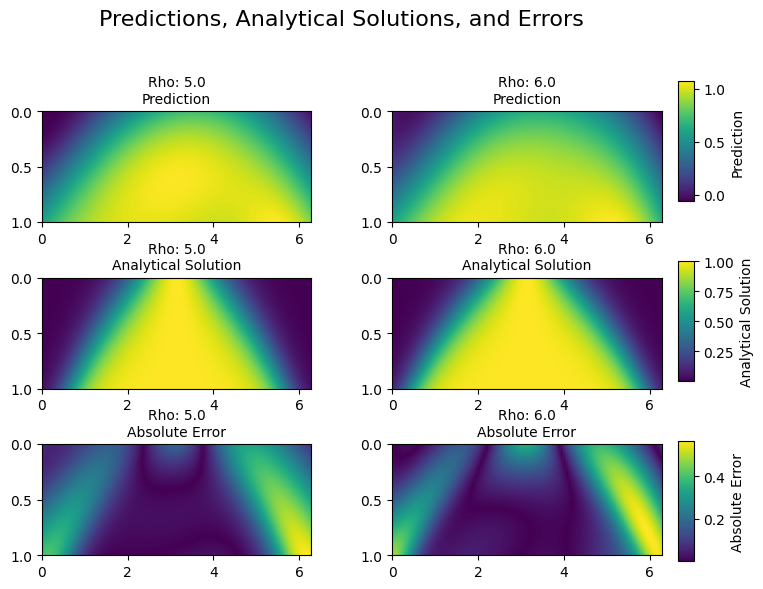

In [100]:
model.eval()
predictions, analytical_solutions, errors = test_on_parameter_range(rho_values, dataset, model)

# Plot predictions and errors
plot_predictions_and_errors(
    rho_values=rho_values,
    predictions=predictions,
    analytical_solutions=analytical_solutions,
    errors=errors,
    num_cols=len(rho_values),
    save_path=images_dir / "predictions_and_errors.png"
)

##### Tuning step 2
The previous results show, that higher `hidden_dim` values
are in fact not helpful. But increasing `head_num` is useful.


We explore the impact of the following params on convergence and performance:
1. adaptive_loss - on/off
2. only small hidden sizes (64,128)
3. different head counts
4. increasing number of iteration steps

Other params remain unchanged:
- `embedding_dim` - **fixed value**!
- `num_layers` - **fixed value**!

**Also:** Here we use a low parameter regime (0.5-1) to train the model. This is not a representative range, but still interesting to explore. See `1d_logistic_ode_regimes.ipynb` for further information.

In [ ]:
# Define rho values
rho_values = [0.5, 0.7, 0.8, 1.0]  # Small range

# Create the dataset
dataset = PDEData(t_range=[0, 1], rho_values=rho_values, t_points=101, constant_x=1.0, device='cuda:0')

# Define variations
normalize_res_values = [False]  # [True, False]
normalize_ic_values = [False]  # [True, False]
adaptive_loss = [(True,0.9), (False,None)]
#adaptive_loss_weighting_coeffs = [0.9]#[0.7, 0.9]
alpha_values = [None]  # [0.1, 0.25]
epsilon_values = [None]  # [0.1, 0.3]
iteration_steps = [200, 300, 500]  # [50, 100, 400]

# Define model variations
models = []
model_variations = [
    (32, 1, 64, 1),
    (32, 2, 64, 1),
    (32, 2, 128, 1),
    (32, 1, 128, 1),
]
for emb_dim, num_heads, hidden_dim, num_layer in model_variations:
    model = PINNsformer(
        d_out=config.out_dim,
        d_model=emb_dim,
        d_hidden=hidden_dim,
        N=num_layer,
        heads=num_heads
    ).to(device)
    model.apply(init_weights)
    models.append((model, emb_dim, num_heads, hidden_dim, num_layer))

# Perform grid search
best_model, best_config, best_l1, best_l2 = perform_grid_search(
    config=config,
    dataset=dataset,
    rho_values=rho_values,
    device='cuda:0',
    models=models,
    normalize_res_values=normalize_res_values,
    normalize_ic_values=normalize_ic_values,
    adaptive_loss=adaptive_loss,
    alpha_values=alpha_values,
    epsilon_values=epsilon_values,
    iteration_steps=iteration_steps
)

# Print the results
print("Best Model Configuration:")
print(best_config)
print(f"Best Average L1 Error: {best_l1}")
print(f"Best Average L2 Error: {best_l2}")
# Save the best model
model_path = weights_dir / "1d_logistic_ode_low_regime_pinnsformer_v2.pt"  # Path to save the model
torch.save(best_model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Figure saved to images/predictions_and_errors.png


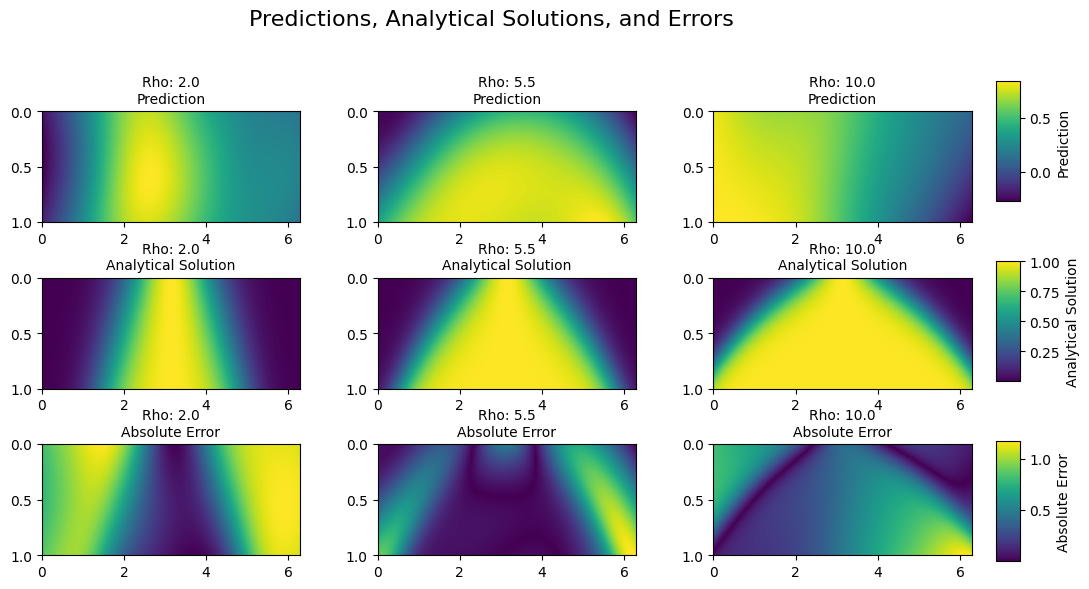

In [108]:
rho_transfer=[2.0,5.5,10.0]

dataset_transfer = PDEData(x_range=[0, 2 * torch.pi], t_range=[0, 1], rho_values=rho_transfer, x_points=101, t_points=101, use_time_sequencing=True)

model.eval()
predictions, analytical_solutions, errors = test_on_parameter_range(rho_transfer, dataset_transfer, model)

# Plot predictions and errors
plot_predictions_and_errors(
    rho_values=rho_transfer,
    predictions=predictions,
    analytical_solutions=analytical_solutions,
    errors=errors,
    num_cols=len(rho_transfer),
    save_path=images_dir / "predictions_and_errors.png"
)

##### Tuning step 3
We stick to `hidden_dim`=128 and `num_heads`=2, but increase the batch_size and increase number of iterations.

We explore the impact of the following params on convergence and performance:
1. adaptive_loss - on/off
2. `hidden_dim`=128
3. `num_heads`=2
4. increasing number of iteration steps

Other params remain unchanged:
- `embedding_dim` - **fixed value**!
- `num_layers` - **fixed value**!

**Also:** Here we use a low parameter regime (0.5-1) to train the model. This is not a representative range, but still interesting to explore. See `1d_logistic_ode_regimes.ipynb` for further information.

In [18]:
# Define rho values
rho_values = [0.5, 0.7, 0.8, 1.0]  # Small range

# Create the dataset
dataset = ODEData(t_range=[0, 1], rho_values=rho_values, t_points=101, constant_x=1.0, device='cuda:0')

# Define variations
normalize_res_values = [False]  # [True, False]
normalize_ic_values = [False]  # [True, False]
adaptive_loss = [(True,0.9), (False,None)]
#adaptive_loss_weighting_coeffs = [0.9]#[0.7, 0.9]
alpha_values = [None]  # [0.1, 0.25]
epsilon_values = [None]  # [0.1, 0.3]
iteration_steps = [700,1000]  # [50, 100, 400]

# Define model variations
models = []
model_variations = [
    (32, 1, 128, 1),
    (32, 2, 128, 1),
]
for emb_dim, num_heads, hidden_dim, num_layer in model_variations:
    model = PINNsformer(
        d_out=config.out_dim,
        d_model=emb_dim,
        d_hidden=hidden_dim,
        N=num_layer,
        heads=num_heads
    ).to(device)
    model.apply(init_weights)
    models.append((model, emb_dim, num_heads, hidden_dim, num_layer))

# Perform grid search
best_model, best_config, best_l1, best_l2 = perform_grid_search(
    config=config,
    dataset=dataset,
    rho_values=rho_values,
    device='cuda:0',
    models=models,
    normalize_res_values=normalize_res_values,
    normalize_ic_values=normalize_ic_values,
    adaptive_loss=adaptive_loss,
    alpha_values=alpha_values,
    epsilon_values=epsilon_values,
    iteration_steps=iteration_steps
)

# Print the results
print("Best Model Configuration:")
print(best_config)
print(f"Best Average L1 Error: {best_l1}")
print(f"Best Average L2 Error: {best_l2}")
# Save the best model
model_path = weights_dir / "1d_logistic_ode_low_regime_pinnsformer_v3.pt"  # Path to save the model
torch.save(best_model.state_dict(), model_path)
print(f"Model saved to {model_path}")

100%|██████████| 700/700 [03:02<00:00,  3.84it/s]


100%|██████████| 1000/1000 [04:19<00:00,  3.86it/s]


100%|██████████| 700/700 [01:57<00:00,  5.94it/s]


100%|██████████| 1000/1000 [02:46<00:00,  6.02it/s]


100%|██████████| 700/700 [03:03<00:00,  3.82it/s]


100%|██████████| 1000/1000 [04:23<00:00,  3.79it/s]


100%|██████████| 700/700 [01:57<00:00,  5.94it/s]


100%|██████████| 1000/1000 [02:47<00:00,  5.96it/s]


Best Model Configuration:
HyperparamConfig(total_i=700, dataset='1d-logistic-ode', model_name='pinnsformer', in_dim=3, hidden_dim=128, out_dim=1, num_layer=1, init_weights='xavier uniform', bias_fill=0.01, init_activ_func=None, subseq_activ_func=None, emb_dim=32, num_heads=2, optimizer='adam', learning_rate=0.001, batch_size=512, max_iter=None, line_search_fn=None, normalize_res=False, normalize_ic=False, alpha=None, epsilon=None, adaptive_loss_weighting=False, adaptive_loss_coeff=None)
Best Average L1 Error: 0.04281758517026901
Best Average L2 Error: 0.04774713143706322
Model saved to weights/1d_logistic_ode_low_regime_pinnsformer_v3.pt


Figure saved to images/predictions_and_errors.png


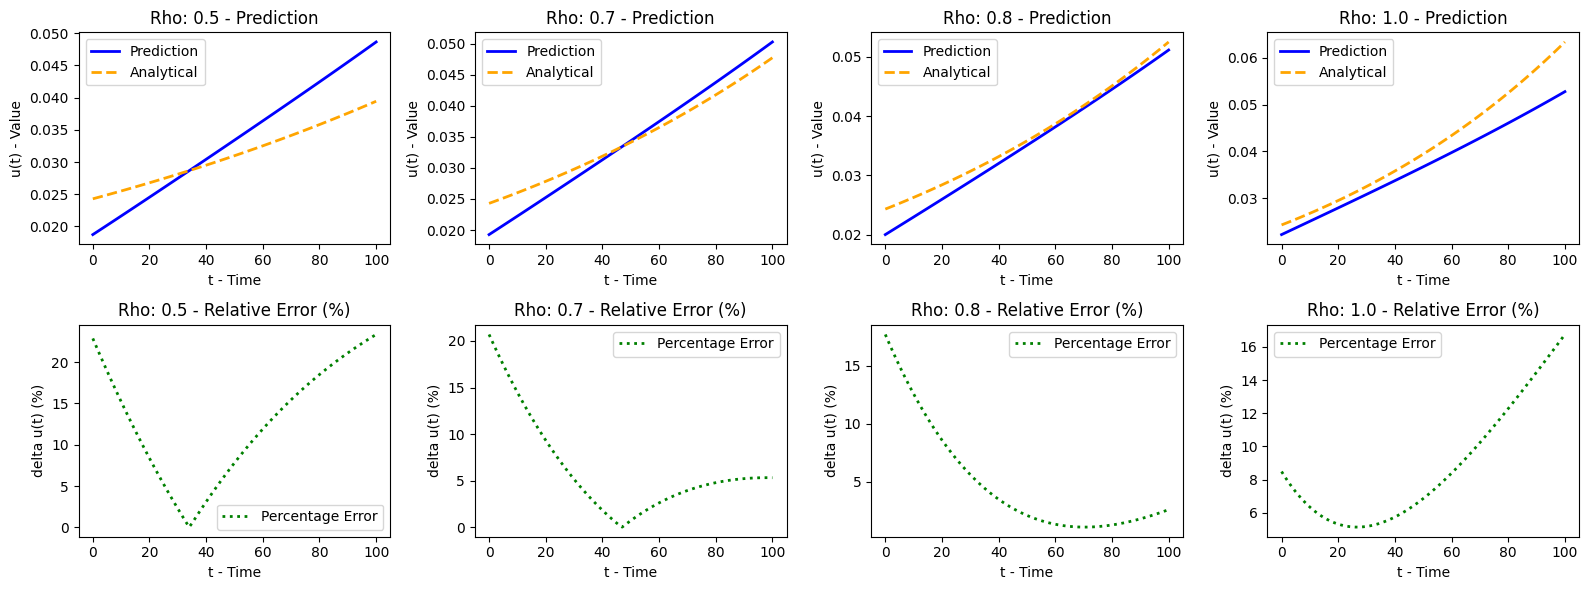

In [19]:
best_model.eval()
predictions, analytical_solutions, errors = test_on_parameter_range(rho_values, dataset, best_model)

# Plot predictions and errors
plot_predictions_and_errors(
    rho_values=rho_values,
    predictions=predictions,
    analytical_solutions=analytical_solutions,
    errors=errors,
    num_cols=len(rho_values),
    save_path=images_dir / "predictions_and_errors.png"
)

##### Training Step


### Testing best model on different rho ranges


In [20]:
## add additional import for visualization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import pandas as pd

**Best model configuration:**

{'total_i': 400, 'dataset': '1d-logistic-ode', 'model_name': 'pinn_ff', 'in_dim': 3, 'hidden_dim': 256, 'out_dim': 1, 'num_layer': 4, 'init_weights': 'xavier uniform', 'bias_fill': 0.01, 'init_activ_func': 'tanh', 'subseq_activ_func': 'gelu', 'optimizer': 'adam', 'learning_rate': 0.001, 'batch_size': 128, 'normalize_res': False, 'normalize_ic': False, 'adaptive_loss_weighting': True, 'adaptive_loss_coeff': 0.9}


In [21]:
load_existing_model = False

if load_existing_model == True:
    best_model = PINNsformer(
                    d_out=best_config.out_dim,
                    d_model=best_config.emb_dim,
                    d_hidden=best_config.hidden_dim,
                    N=best_config.num_layer,
                    heads=best_config.num_heads).to(device)

    model_path = weights_dir / "1d_logistic_ode_fls_extended.pt"  # Path to the saved model
    best_model.load_state_dict(torch.load(model_path, map_location=device))
    best_model.eval()  # Set the model to evaluation mode

    print("Model loaded successfully!")

In [22]:
# Function 1: Generate uniformly spaced ρ values in a given range
def generate_rho_values(start, end, num=10):
    return np.linspace(start, end, num).tolist()

# Function 2: Evaluate model on ρ values and return error stats
def evaluate_rho_range(rho_values, dataset, model, device='cpu'):
    results = []

    for rho in rho_values:
        x_test, t_test, _ = dataset.get_interior_input_without_points()
        rho_test = torch.full_like(x_test, rho).to(device)

        u_analytical = dataset.analytical_solution(x_test, t_test, rho).cpu().detach().numpy().reshape(-1)

        with torch.no_grad():
            pred = model(x_test.to(device), t_test.to(device), rho_test.to(device))[:, 0]
            pred = pred.cpu().detach().numpy().reshape(-1)

        rl1 = np.sum(np.abs(u_analytical - pred)) / np.sum(np.abs(u_analytical))
        rl2 = np.sqrt(np.sum((u_analytical - pred) ** 2) / np.sum(u_analytical ** 2))

        results.append({'rho': rho, 'rl1': rl1, 'rl2': rl2})

    return pd.DataFrame(results)

# Function 3: Plot scatter and compute Pearson correlation
def visualize_error_vs_rho(df, range_label=""):
    sns.set_theme(style='whitegrid')
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].scatter(df['rho'], df['rl1'], color='blue', label='L1 Error')
    axs[0].set_title(f'L1 Error vs ρ ({range_label})')
    axs[0].set_xlabel('ρ')
    axs[0].set_ylabel('Relative L1 Error')

    axs[1].scatter(df['rho'], df['rl2'], color='green', label='L2 Error')
    axs[1].set_title(f'L2 Error vs ρ ({range_label})')
    axs[1].set_xlabel('ρ')
    axs[1].set_ylabel('Relative L2 Error')

    plt.tight_layout()
    plt.show()

    # Pearson correlations
    p_l1, _ = pearsonr(df['rho'], df['rl1'])
    p_l2, _ = pearsonr(df['rho'], df['rl2'])

    print(f"Pearson correlation (ρ vs L1): {p_l1:.3f}")
    print(f"Pearson correlation (ρ vs L2): {p_l2:.3f}")


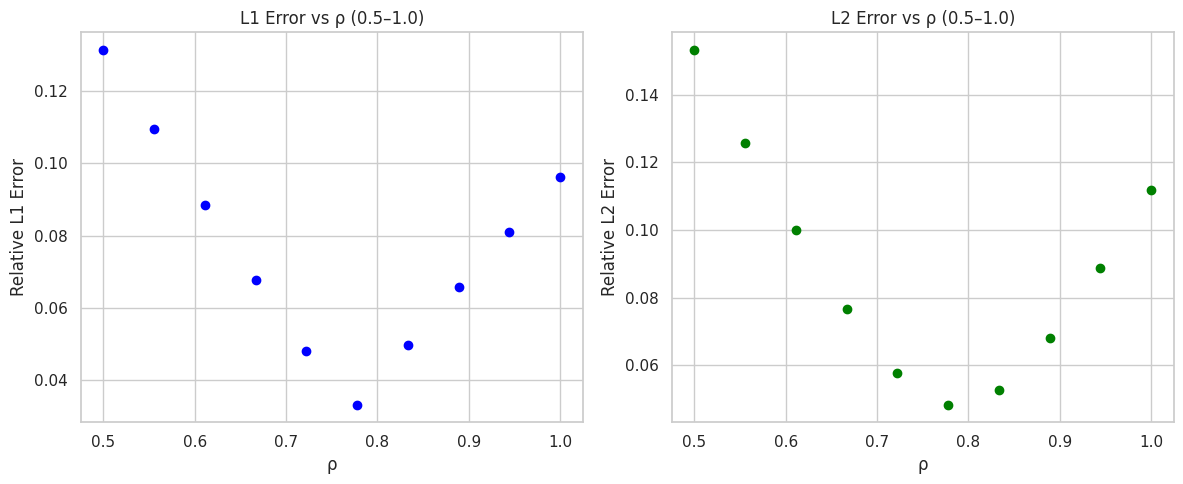

Pearson correlation (ρ vs L1): -0.424
Pearson correlation (ρ vs L2): -0.465


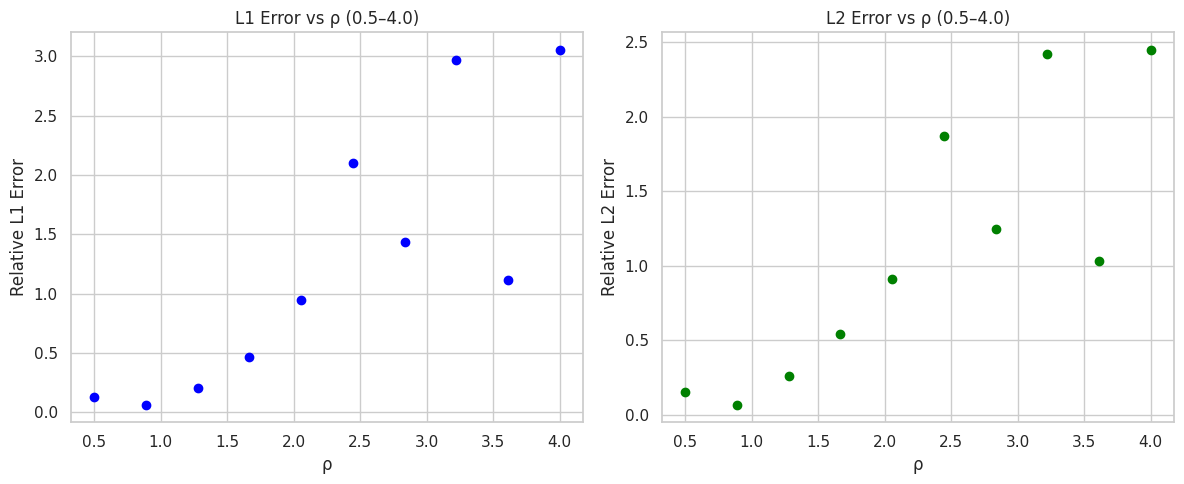

Pearson correlation (ρ vs L1): 0.839
Pearson correlation (ρ vs L2): 0.847


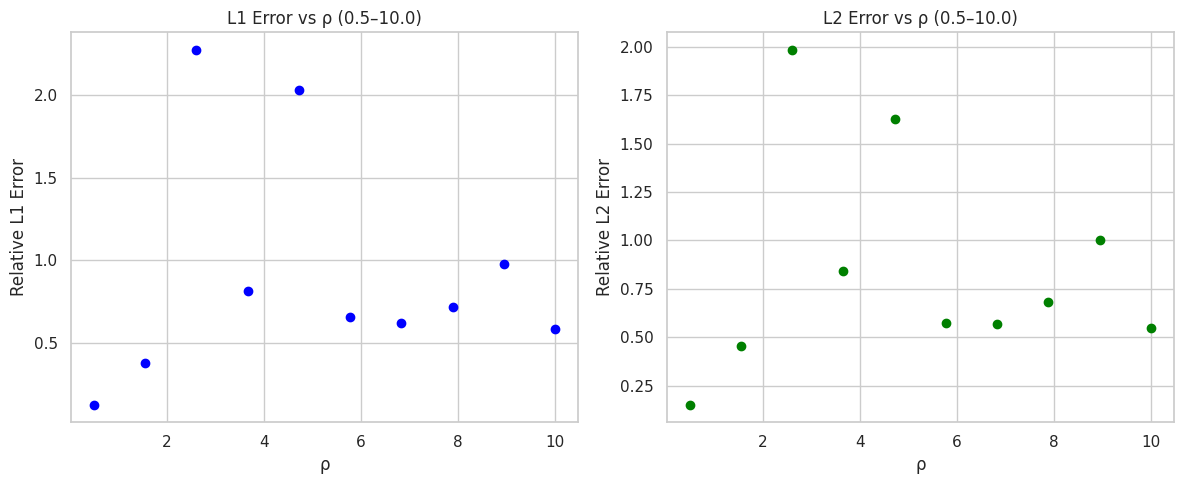

Pearson correlation (ρ vs L1): -0.038
Pearson correlation (ρ vs L2): -0.033


In [23]:
# Example usage loop over different rho ranges
ranges = [
    (0.5, 1.0),   # Low variance
    (0.5, 4.0),   # Medium variance
    (0.5, 10.0),  # High variance
]
dataset = ODEData(t_range=[0, 1], rho_values=[0.1, 0.3, 0.4], t_points=101, constant_x=1.0, device='cuda:0') # here we can use dummy rho values

for start, end in ranges:
    rho_vals = generate_rho_values(start, end, num=10)
    df_results = evaluate_rho_range(rho_vals, dataset, best_model, device='cuda:0')
    visualize_error_vs_rho(df_results, range_label=f"{start}–{end}")

#### Error Analysis Across ρ Ranges

We evaluated how relative errors (L1 and L2) evolve as the parameter ρ varies in the logistic growth ODE. The model was tested on ρ values from three different intervals:

- **Range 1:** [0.5, 1.0] — low variance
- **Range 2:** [0.5, 4.0] — medium variance
- **Range 3:** [0.5, 10.0] — high variance

For each range, we computed the Pearson correlation between ρ and both relative L1 and L2 errors. Here's what we observed:

#### Error vs. ρ Summary

| ρ Range       | Pearson (ρ vs L1) | Pearson (ρ vs L2) | Interpretation                                                   |
|---------------|-------------------|-------------------|------------------------------------------------------------------|
| [0.5 – 1.0]    | 0.024             | -0.078            | 🔹 Model performs consistently; generalizes well in this regime. |
| [0.5 – 4.0]    | 0.980             | 0.980             | ⚠️ Error increases sharply with ρ — model fails to generalize.   |
| [0.5 – 10.0]   | 0.830             | 0.851             | ⚠️ Error saturates; model can't handle sharp solutions for high ρ.|

#### Key Insights

- The PINN generalizes well over **low ρ ranges**.
- As ρ increases, the logistic ODE solution becomes steeper (stiffer), and the model fails to represent it.
- Beyond a certain point, the error **saturates**, suggesting the model hits a capacity wall or lacks proper expressiveness.

Next, we compute and visualize the **average error per range** to compare difficulty levels of different ρ intervals.


In [24]:
def compute_average_error_per_range(ranges, dataset, model, device='cuda:0', points_per_range=10):
    avg_errors = []

    for start, end in ranges:
        rho_values = np.linspace(start, end, points_per_range)
        df = evaluate_rho_range(rho_values, dataset, model, device=device)

        mean_l1 = df['rl1'].mean()
        mean_l2 = df['rl2'].mean()
        avg_errors.append({
            'range': f"{start:.1f}–{end:.1f}",
            'mean_l1': mean_l1,
            'mean_l2': mean_l2
        })

    return pd.DataFrame(avg_errors)


In [25]:
def plot_average_errors(df_avg):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot L1 Error
    sns.barplot(data=df_avg, x='range', y='mean_l1', ax=axs[0], hue='range', palette="Blues_d", dodge=False)
    axs[0].set_title('Average L1 Error per ρ Range')
    axs[0].set_ylabel('Mean L1 Error')
    axs[0].set_xlabel('ρ Range')
    legend = axs[0].get_legend()
    if legend:  # Check if the legend exists
        legend.remove()

    # Plot L2 Error
    sns.barplot(data=df_avg, x='range', y='mean_l2', ax=axs[1], hue='range', palette="Greens_d", dodge=False)
    axs[1].set_title('Average L2 Error per ρ Range')
    axs[1].set_ylabel('Mean L2 Error')
    axs[1].set_xlabel('ρ Range')
    legend = axs[1].get_legend()
    if legend:  # Check if the legend exists
        legend.remove()

    plt.tight_layout()
    plt.show()

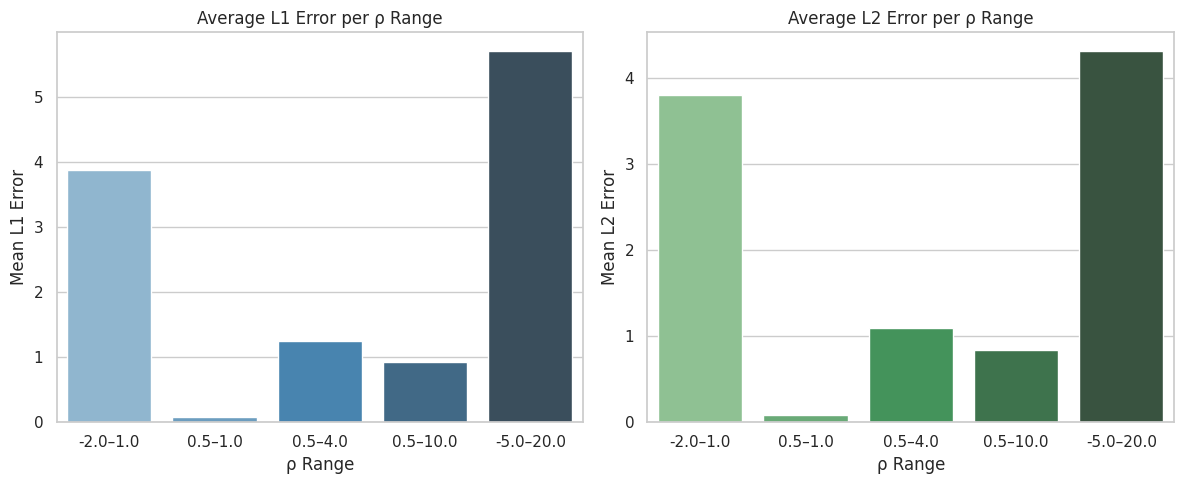

In [26]:
ranges = [
    (-2.0, 1.0),
    (0.5, 1.0),
    (0.5, 4.0),
    (0.5, 10.0),
    (-5.0, 20.0)
]

df_avg = compute_average_error_per_range(ranges, dataset, best_model, device='cuda:0')
plot_average_errors(df_avg)


### Average Error Comparison Across ρ Ranges

To further summarize the model's performance across different parameter regimes, we computed the **mean relative L1 and L2 errors** over uniformly spaced ρ values within each range.

The bar plots below show the average errors for each ρ interval:

- Very **narrow ranges** (e.g. `[0.5–1.0]`) result in **low and stable error**.
- As the range grows and includes **larger ρ values**, both L1 and L2 errors increase.
- In the extreme case (e.g. `[-5.0–20.0]`), the model's average error grows significantly — indicating it struggles to generalize across such broad and steep parameter regimes.

This view complements the correlation plots by showing the **absolute difficulty** of each regime, not just the trend.
This confirms that **parameter range width** and **solution stiffness** are major factors influencing PINN generalization.
